# Scraping Periódico ElColombiano

### Librerías

In [1]:
import requests
from bs4 import BeautifulSoup
import datetime
import locale
import pandas as pd
import matplotlib.pyplot as plt

### Función para acceder a las noticias de la página principal

In [2]:
def pagina_general(url):
    pagina_inicial = requests.get(url)
    pagina_inicial = BeautifulSoup(pagina_inicial.text, "html.parser")

    link = pagina_inicial.find(name="h3", attrs={"class" : "title__noticia__principal"}).find("a")
    principal = link.get("href")

    link1 = pagina_inicial.find(name="div", attrs={"class" : "ec-teaser-noticia-seccion-metadatos"}).find("a")
    izq_up = link1.get("href")

    link2 = pagina_inicial.find(name="div", attrs={"class" : "width-60 text__noticia__columna__ultimas"})
    izq_down = link2.find(name="a", attrs={"class" : "google__ultimas__noticias"})
    izq_down = izq_down.get("href")

    link3 = pagina_inicial.find(name="section", attrs={"class" : "teaser-related-list teaser-related-internal-links teaser-related-external-links"}).find_all("a")
    pequenio = []
    for i in link3:
        links = i.get("href")
        if links == None:
            pequenio.append(None)
        else:
            pequenio.append(links)

    link4 = pagina_inicial .find(name="div", attrs={"class" : "col-xs-12 col-sm-3 col-md-3 portlet-column"}).find_all("div")
    der_up = []
    for i in link4:
        links = i.get("data-urldestination")
        if links == None:
            continue
        else:
            der_up.append(links)

    link5 = pagina_inicial.find(name="div", attrs={"class" : "portlet-boundary portlet-static-end teaser-viewer-portlet noticias__column__grid3 secundarias_seguimiento"}).find_all("article")
    centro =  [i.a.get("href") for i in link5]
    
    # link6 = pagina_inicial.find(name="div", attrs={"class" : "seccion__general iter-portal-size iter-portal-size-content"}).find_all("h3")
    

    listado = principal, izq_up, izq_down
    listado = list(listado)
    listado = listado + pequenio + der_up + centro

    links = [url + i for i in listado]
    news = {}
    news["general"] = []

    for i in links:
        page = requests.get(i)
        page = BeautifulSoup(page .text, "html.parser")

        # titulo
        titulo_code = page.find("title")
        titulo_uncode = titulo_code.get_text()
        titulo = titulo_uncode.encode('iso-8859-1').decode('utf-8')

        # fecha
        try:
            fofo = page.find(name="div", attrs={"class" : "container__compartir"}).find("span")
            fechita = fofo.get_text()
            fechita = str(fechita)
            # if fechita == " hace 1 hora " or fechita == " hace 2 horas " or fechita == " hace 3 horas " or fechita == " hace 4 horas " or fechita == " hace 5 horas ":
            if len(fechita) < 19:    
                locale.setlocale(locale.LC_TIME, "es_ES.UTF-8") # Configurar el idioma local
                fechita = datetime.datetime.now().strftime('%d de %B de %Y')
            else:
                fechita = fechita.strip() # quitar primer y ultmo espacio de los valores
        except Exception as e:
            None
            
        # diccionario
        news["general"].append({
                                "Titulo" : titulo,
                                "Fecha" : fechita,
                                "Url" : i
                                })
    return news




### Invocar funcion con la URL de la página principal de ElColombiano

In [3]:
url = "https://www.elcolombiano.com"
diccionario = pagina_general(url)

# Print para inspeccionar el diccionario con los primeros 5 registros
# dicc = diccionario["general"]
# dicc[:5]

### Crear DataFrame con las noticias de la página principal

In [4]:
df_principal = pd.DataFrame(diccionario["general"])
df_principal["Categoria"] = "Principal"
df_principal = df_principal.reindex(columns=['Categoria', 'Titulo', 'Fecha', 'Url'])

# Mostrar primeros 5 registros
df_principal.head(5)

,Categoria,Titulo,Fecha,Url
0,Principal,La bitácora secreta del ataque de las barras e...,22 de abril de 2023,https://www.elcolombiano.com/deportes/futbol/l...
1,Principal,En vivo: Real Madrid pierde parcialmente ante ...,23 de abril de 2023,https://www.elcolombiano.com/deportes/futbol/l...
2,Principal,Las 128 horas de vuelo de Francia Márquez han ...,23 de abril de 2023,https://www.elcolombiano.com/colombia/politica...
3,Principal,Cámaras del estadio no sirvieron para detectar...,22 de abril de 2023,https://www.elcolombiano.com/deportes/futbol/c...
4,Principal,"Ante el mal comportamiento de Los del Sur, ref...",22 de abril de 2023,https://www.elcolombiano.com/antioquia/nuevas-...


### Función para acceder a las noticias de la página de deportes

In [5]:
def deportes_urls(url):
    deportes = requests.get(url)
    deportes = BeautifulSoup(deportes.text, "html.parser")
    
    todos  = deportes.find_all(name="article", attrs={"class" : "article element full-access norestricted"})
    all_news = []

    for i in todos:
        campos = i.h3
        if campos == None:
            continue
        all_news.append(campos.a.get("href"))
    primeros = all_news[:12]
    segundos = all_news[35:38]
    otros = all_news[38:50]

    links = []
    for i in primeros:
        links.append(url + i)
    for j in segundos:
        links.append(url + j)
    for k in otros:
        links.append(url + k)

    news = {}
    news["deportes"] = []

    for i in links:

        # Entrar a la pagina de cada url
        page = requests.get(i)
        page = BeautifulSoup(page.text, "html.parser")

        # titulo
        titulo_code = page.find("title")
        titulo_uncode = titulo_code.get_text()
        titulo = titulo_uncode.encode('iso-8859-1').decode('utf-8')
        
        # fecha
        try:
            fofo = page.find(name="div", attrs={"class" : "container__compartir"}).find("span")
            fechita = fofo.get_text()
            fechita = str(fechita)
            # if fechita == " hace 1 hora " or fechita == " hace 2 horas " or fechita == " hace 3 horas " or fechita == " hace 4 horas " or fechita == " hace 5 horas ":    
            if len(fechita) < 19:
                locale.setlocale(locale.LC_TIME, "es_ES.UTF-8") # Configurar el idioma local
                fechita = datetime.datetime.now().strftime('%d de %B de %Y')
            else:
                fechita = fechita.strip() # quitar primer y ultmo espacio de los valores
        except Exception as e:
            None

        # diccionario
        news["deportes"].append({
                                "Categoria" : "Deportes",
                                "Titulo" : titulo,
                                "Fecha" : fechita,
                                "Url" : i
                                })
    return news



### Crear DataFrame con las noticias de la página de deportes

In [6]:
url_deportes = "https://www.elcolombiano.com/deportes"
news_deportes = deportes_urls(url_deportes)
df_deportes = pd.DataFrame(news_deportes["deportes"])

# Mostrar primeros 5 registros
df_deportes.head(5)

,Categoria,Titulo,Fecha,Url
0,Deportes,La bitácora secreta del ataque de las barras e...,22 de abril de 2023,https://www.elcolombiano.com/deportes/deportes...
1,Deportes,‘Deiqui’ recupera brillo en su tercera etapa c...,22 de abril de 2023,https://www.elcolombiano.com/deportes/deportes...
2,Deportes,Envigado recibe a Nacional en un duelo para re...,22 de abril de 2023,https://www.elcolombiano.com/deportes/deportes...
3,Deportes,En vivo: Real Madrid pierde parcialmente ante ...,23 de abril de 2023,https://www.elcolombiano.com/deportes/deportes...
4,Deportes,Tadej Pogacar sufrió una fractura y será opera...,23 de abril de 2023,https://www.elcolombiano.com/deportes/deportes...


### Función para acceder a las noticias de las demás páginas

In [7]:
def escoger_urls(url):
    pagina_inicial = requests.get(url)
    pagina_inicial = BeautifulSoup(pagina_inicial.text, "html.parser")
    pagina_inicial = pagina_inicial.find(name="ul", attrs={"class" : "nav__seccion__list display-flex"}).find_all("li")

    sec_pagina_inicial = [i.a.get("href") for i in pagina_inicial]

    principal = []
    izq_up = []
    izq_down = []
    der_up = []
    centro = []

    for urls in sec_pagina_inicial:
        if urls == None:
            continue
        
        page = requests.get(urls)
        page = BeautifulSoup(page.text, "html.parser")

        try:
            link = page.find(name="h3", attrs={"class" : "title__noticia__principal"}).find("a")
            principal.append(link.get("href"))
        except Exception as e:
            continue
        
        try:
            link1 = page.find(name="div", attrs={"class" : "ec-teaser-noticia-seccion-metadatos"}).find("a")
            izq_up.append(link1.get("href"))
        except Exception as e:
            None

        
        try:
            link2 = page.find(name="div", attrs={"class" : "width-60 text__noticia__columna__ultimas"})
            link2_1 = link2.find(name="a", attrs={"class" : "google__ultimas__noticias"})
            izq_down.append(link2_1.get("href"))
        except Exception as e:
            None

        try:
            link3 = page.find(name="div", attrs={"class" : "col-xs-12 col-sm-3 col-md-3 portlet-column"}).find_all("div")
            for i in link3:
                links = i.get("data-urldestination")
                if links == None:
                    continue
                else:
                    der_up.append(links)
        except Exception as e:
            None

        try: 
            link4 = page.find(name="div", attrs={"class" : "col-xs-12 col-sm-9 col-md-9 portlet-column"}).find_all("div")
            for i in link4:
                links = i.get("data-urldestination")
                if links == None:
                    continue
                else:
                    centro.append(links)
        except Exception as e:
            None
        # print(f"Vamos en este url {urls}")

    listado = principal + izq_up + izq_down
    listado = listado + der_up + centro
    links = [url + i for i in listado]

    news = {}
    news["todos"] = []

    for i in links:
        
        # Catergorias
        if "https://www.elcolombiano.com/medellin" in i:
            categoria = "Medellin"
        elif "https://www.elcolombiano.com/colombia" in i:
            categoria = "Colombia"
        elif "https://www.elcolombiano.com/negocios" in i:
            categoria = "Negocios"
        elif "https://www.elcolombiano.com/antioquia" in i:
            categoria = "Antioquia"
        elif "https://www.elcolombiano.com/internacional" in i:
            categoria = "Internacional"
        elif "https://www.elcolombiano.com/cultura" in i:
            categoria = "Cultura"
        elif "https://www.elcolombiano.com/tendencias"in i:
            categoria = "Tendencias"
        elif "https://www.elcolombiano.com/tecnologia" in i:
            categoria = "Tecnologia"
        elif "https://www.elcolombiano.com/entretenimiento" in i:
            categoria = "Entretenimiento"
        else:
            categoria = "Otros"

        # Entrar a la pagina de cada url
        page = requests.get(i)
        page = BeautifulSoup(page.text, "html.parser")

        # titulo
        titulo_code = page.find("title")
        titulo_uncode = titulo_code.get_text()
        titulo = titulo_uncode.encode('iso-8859-1').decode('utf-8')

        # fecha
        try:
            fofo = page.find(name="div", attrs={"class" : "container__compartir"}).find("span")
            fechita = fofo.get_text()
            fechita = str(fechita)
            # if fechita == " hace 1 hora " or fechita == " hace 2 horas " or fechita == " hace 3 horas " or fechita == " hace 4 horas " or fechita == " hace 5 horas ":    
            if len(fechita) < 19:
                locale.setlocale(locale.LC_TIME, "es_ES.UTF-8") # Configurar el idioma local
                fechita = datetime.datetime.now().strftime('%d de %B de %Y')
            else:
                fechita = fechita.strip() # quitar primer y ultmo espacio de los valores
        except Exception as e:
            None


        # diccionario
        news["todos"].append({
                                "Categoria" : categoria,
                                "Titulo" : titulo,
                                "Fecha" : fechita,
                                "Url" : i
                                })
    return news

### Crear DataFrame con las noticias de las demás páginas

In [8]:
url = "https://www.elcolombiano.com"
the_news = escoger_urls(url)
dicc_news = the_news["todos"]

# Mostrar primeros 5 registros
# dicc_news[:5]

In [9]:
df_el_resto = pd.DataFrame(dicc_news)

# Mostrar primeros 5 registros
df_el_resto.head(5)

,Categoria,Titulo,Fecha,Url
0,Medellin,Cada cinco días un agente de tránsito es golpe...,21 de abril de 2023,https://www.elcolombiano.com/medellin/ataques-...
1,Colombia,Cinco megacarteles y 23 narcobandas: así es el...,22 de abril de 2023,https://www.elcolombiano.com/colombia/cuales-s...
2,Negocios,“Lo que yo ejecuto son las decisiones del pres...,22 de abril de 2023,https://www.elcolombiano.com/negocios/lo-que-y...
3,Antioquia,Multinacional Mineros habla del paro en el Baj...,23 de abril de 2023,https://www.elcolombiano.com/antioquia/entrevi...
4,Internacional,"Alejandro Toledo, expresidente de Perú, pide d...",22 de abril de 2023,https://www.elcolombiano.com/internacional/ale...


### Unificar los DataFrames

In [10]:
# Unir dataframes
df_concat = pd.concat([df_principal, df_deportes, df_el_resto], ignore_index=True)
df_concat

# Mostrar registros del 11 al 13
# df_concat.iloc[11:14]


,Categoria,Titulo,Fecha,Url
0,Principal,La bitácora secreta del ataque de las barras e...,22 de abril de 2023,https://www.elcolombiano.com/deportes/futbol/l...
1,Principal,En vivo: Real Madrid pierde parcialmente ante ...,23 de abril de 2023,https://www.elcolombiano.com/deportes/futbol/l...
2,Principal,Las 128 horas de vuelo de Francia Márquez han ...,23 de abril de 2023,https://www.elcolombiano.com/colombia/politica...
3,Principal,Cámaras del estadio no sirvieron para detectar...,22 de abril de 2023,https://www.elcolombiano.com/deportes/futbol/c...
4,Principal,"Ante el mal comportamiento de Los del Sur, ref...",22 de abril de 2023,https://www.elcolombiano.com/antioquia/nuevas-...
...,...,...,...,...
139,Tecnologia,"Cancelado el lanzamiento del Starship, el pode...",17 de abril de 2023,https://www.elcolombiano.com/tecnologia/cancel...
140,Tecnologia,"Así será el despegue del poderoso Starship, el...",17 de abril de 2023,https://www.elcolombiano.com/tecnologia/despeg...
141,Tecnologia,Tres apps que le ayudan a borrar objetos y per...,16 de abril de 2023,https://www.elcolombiano.com/tecnologia/aplica...
142,Tecnologia,Twitter ya permite trinos de hasta 10.000 cara...,15 de abril de 2023,https://www.elcolombiano.com/tecnologia/twitte...


### Exportar el DataFrame unificado a formato .csv

In [11]:
# Elegir nombre del archivo en base a la fecha del dia de hoy
now = datetime.datetime.now().strftime('%d_%B_%Y') # ejemplo de nombre de archivo: 23_abril_2023.csv 

# Exportar en formato .CSV
df_concat.to_csv(f'{now}.csv', index=False)

### Información del DataFrame

In [12]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Categoria  144 non-null    object
 1   Titulo     144 non-null    object
 2   Fecha      144 non-null    object
 3   Url        144 non-null    object
dtypes: object(4)
memory usage: 4.6+ KB


### Gráficos de barras

Contenido:

 Categoria
Deportes         27
Colombia         19
Negocios         16
Tecnologia       15
Medellin         14
Antioquia        14
Cultura          14
Principal        12
Internacional    11
Otros             1
Tendencias        1
Name: count, dtype: int64


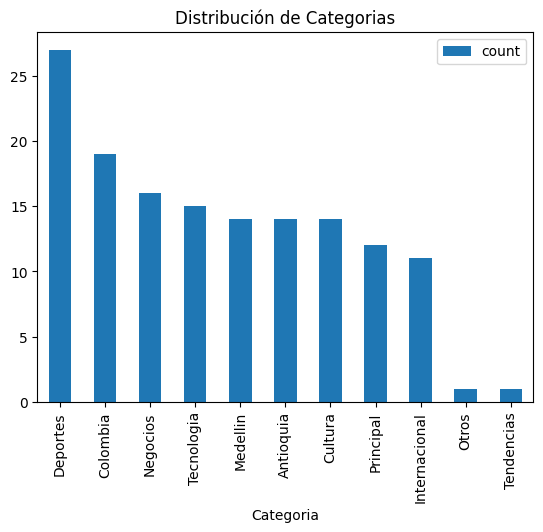

In [13]:
# Contenido
counts_categoria = df_concat['Categoria'].value_counts()
print("Contenido:" + "\n"*2 , counts_categoria)

# Grafico
counts_categoria.plot(kind='bar')
plt.legend()
plt.title('Distribución de Categorias')
plt.show()


Contenido:

 Fecha
22 de abril de 2023    59
21 de abril de 2023    47
23 de abril de 2023    12
20 de abril de 2023     4
17 de abril de 2023     4
Name: count, dtype: int64


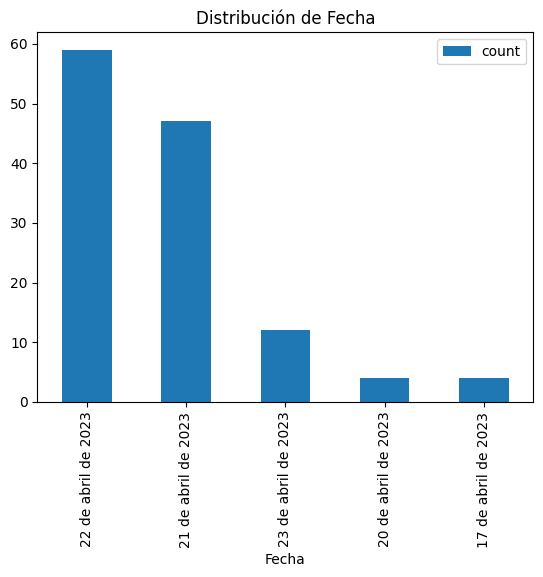

In [14]:
# Contenido
counts_fecha = df_concat['Fecha'].value_counts().head() # Mostrar las primeras 5 fechas con mas distribucion
print("Contenido:" + "\n"*2 ,counts_fecha)

# Grafico
counts_fecha.plot(kind='bar')
plt.legend()
plt.title('Distribución de Fecha')
plt.show()